In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import colormaps as cm
from matplotlib.patches import Circle, Rectangle
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from defaults import *
from read_data import *
from plot_functions import *

In [12]:
def plot_slice(folder_path, slice):
    Re, NX, NY, LX, LY, L, U, nu, dx, dy, dt, T, obstacle, w_on, animation_on = readSetupFromHDF5(
        '../output/setup.h5')
    num_frames = get_num_frames(folder_path)
    times, u, v, w, p = set_data(folder_path)

    # change to whatever you want to plot
    # data = np.sqrt(u ** 2 + v ** 2)
    data = w
    data_blocks = []
    for i in range(num_frames):
        data_blocks.append(np.mean(data[i, :, slice]))
    data_blocks = np.array(data_blocks) 

    fig, ax = plt.subplots()
    ax.plot(times, data_blocks)
    plt.show()


def plot(folder_path, folder_object, slice_time, obstacle, vorticity): 
    Re, NX, NY, LX, LY, L, U, nu, dx, dy, dt, T, obstacle, w_on, animation_on = readSetupFromHDF5(
        '../output/setup.h5')
    w_on = vorticity
    color = get_color(w_on)

    num_frames = get_num_frames(folder_path)
    
    if slice_time < 0 or slice_time >= num_frames:
        print("Slice time out of range")
        return
    
    times, u, v, w, p = set_data(folder_path)

    t = times[slice_time]
    u = u[slice_time]
    v = v[slice_time]
    w = w[slice_time]
    p = p[slice_time]

    nx = NX - 2
    ny = NY - 2

    X, Y = set_axis(dx, dy, LX, LY, nx, ny)

    # change to whatever you want to plot
    data = set_datablocks(w_on, u, v, w)

    Z_MAX, Z_MIN = set_Z_max_min(data, w_on)

    plot_args = get_plot_args(dx, LX, LY, Z_MIN, Z_MAX, color)

    fig, ax = plt.subplots()

    # Axes
    ax.set_xlabel(X_LABEL)
    ax.set_ylabel(Y_LABEL)
    plt.imshow(data, **plot_args)

    if object != "":
        get_obstacle(obstacle, nx, ax, folder_object)

    plt.colorbar()
    plt.show()

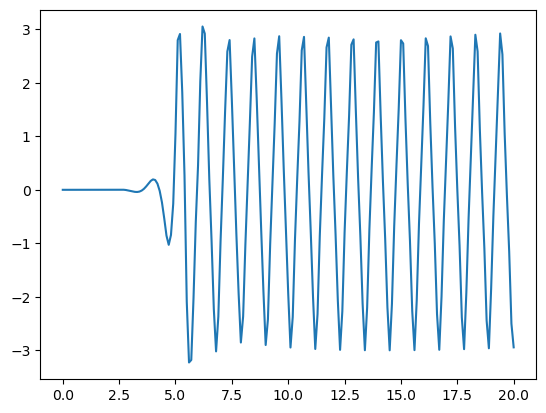

In [13]:
plot_slice("../output/results/",300)

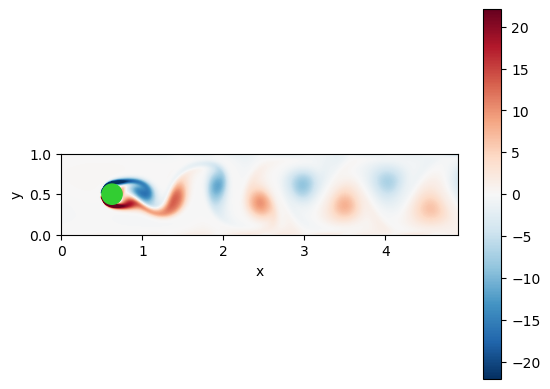

In [11]:
plot("../output/results/", "../config/", 100, "airfoil",True)